In [2]:
import pandas as pd
import pickle
import numpy as np
from fastai.collab import *
from pprint import pprint
import matplotlib.pyplot as plt
# import umap
from scipy import stats
%matplotlib inline

In [2]:
from urllib.request import urlopen
# the original csv from https://raw.githubusercontent.com/beefsack/bgg-ranking-historicals/master/
# The column ID is used in API calls to retrieve the game reviews
link="https://raw.githubusercontent.com/beefsack/bgg-ranking-historicals/master/2019-05-30.csv"
f = urlopen(link)
games = pd.read_csv(f)
games.describe()
games.sort_values('Users rated',ascending=False,inplace=True)
games.rename(index=str, columns={"Bayes average": "Geekscore",'Name':'name'}, inplace=True)
games[:10]

,ID,name,Year,Rank,Average,Geekscore,Users rated,URL,Thumbnail
326,13,Catan,1995,327,7.19,7.036,85268,/boardgame/13/catan,https://cf.geekdo-images.com/micro/img/e0y6Bog...
151,822,Carcassonne,2000,152,7.43,7.321,84982,/boardgame/822/carcassonne,https://cf.geekdo-images.com/micro/img/z0tTaij...
74,30549,Pandemic,2008,75,7.64,7.545,83409,/boardgame/30549/pandemic,https://cf.geekdo-images.com/micro/img/0m3-oqB...
44,68448,7 Wonders,2010,45,7.78,7.689,69074,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/micro/img/h-Ejv31...
75,36218,Dominion,2008,76,7.64,7.544,68245,/boardgame/36218/dominion,https://cf.geekdo-images.com/micro/img/VYp2s2f...
141,9209,Ticket to Ride,2004,142,7.45,7.344,60518,/boardgame/9209/ticket-ride,https://cf.geekdo-images.com/micro/img/2ytp3TG...
24,31260,Agricola,2007,25,7.99,7.885,57029,/boardgame/31260/agricola,https://cf.geekdo-images.com/micro/img/Snnyt1c...
19,3076,Puerto Rico,2002,20,8.04,7.920,56508,/boardgame/3076/puerto-rico,https://cf.geekdo-images.com/micro/img/ti5gCF_...
208,40692,Small World,2009,209,7.30,7.213,53592,/boardgame/40692/small-world,https://cf.geekdo-images.com/micro/img/TTJkpvN...
59,178900,Codenames,2015,60,7.71,7.622,51149,/boardgame/178900/codenames,https://cf.geekdo-images.com/micro/img/3Ihe0IB...


In [9]:
reviews = pd.read_csv('bgg-16m-reviews.csv',index_col=0,engine="python",error_bad_lines=False)
print(len(reviews))
reviews.head()

Skipping line 4020944: unexpected end of data
4020942


,user,rating,comment,ID,name
0,Paul Gower,10.0,NaN,3,Samurai
1,glanfam,10.0,Variable winning conditions make for great int...,3,Samurai
2,GeoffB,10.0,NaN,3,Samurai
3,Eddy Bee,10.0,Brilliant abstract strategy game - very enjoya...,3,Samurai
4,bobrandt,10.0,I bought this game on chance for DKR 30 (about...,3,Samurai


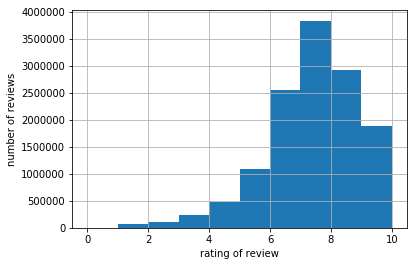

In [22]:
reviews['rating'].hist(bins=10)
plt.xlabel('rating of review')
plt.ylabel('number of reviews')
plt.show()

As you can see,most of the reviews are between a 6 and a 10.

In [23]:
games_by_all_users = reviews.groupby('name')['rating'].agg(['mean','count']).sort_values('mean',ascending=False)
games_by_all_users['rank']=games_by_all_users.reset_index().index+1
print(len(games_by_all_users))

games_by_all_users = games_by_all_users.merge(games[['name','Geekscore']],how='left',left_on=['name'], right_on=['name'])
games_by_all_users.head()

16735


,name,mean,count,rank,Geekscore
0,Limbo: Eternal War,9.597143,35,1,5.507
1,Animator vs Animation,9.588235,34,2,5.510
2,TerroriXico,9.428571,70,3,5.506
3,Arena: The Contest,9.409091,99,4,5.534
4,Court of the Dead: Mourners Call,9.333519,54,5,5.563


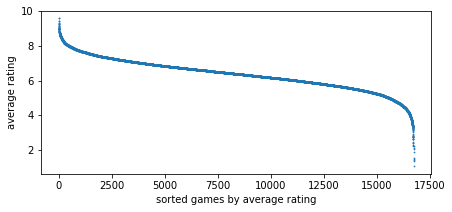

In [24]:
x = games_by_all_users['rank']
y = games_by_all_users['mean']
plt.figure(num=None, figsize=(7, 3), facecolor='w', edgecolor='k')
plt.scatter(x, y,s=0.5)
plt.xlabel('sorted games by average rating')
plt.ylabel('average rating')
plt.show()  # or plt.savefig("name.png")

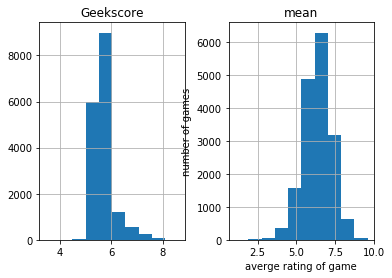

In [25]:
games_by_all_users[['mean','Geekscore']].hist(bins=10)
plt.xlabel('averge rating of game')
plt.ylabel('number of games')
plt.show()

If we compute the average rating of the games, it's even more visible that the ratings are really centered around the mean which is 6.4. The Geekscore is a score which penalizes games when they have few reviews, since the uncertainty around their 'true' score is higher. This is reflected in a lower average score of 5.6

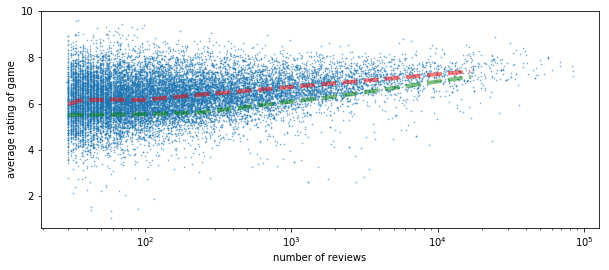

In [26]:
x = games_by_all_users['count']
y = games_by_all_users['Geekscore']
y2 = games_by_all_users['mean']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000,10000,100000])           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin


df2 = pd.DataFrame({'X' : x, 'Y' : y2})  #we build a dataframe from the data
data_cut = pd.cut(df2.X,bins=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000,10000,100000])           #we cut the data following the bins
grp = df2.groupby(by = data_cut)        #we group the data by the cut
ret2 = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df2.X,df2.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.plot(ret2.X,ret2.Y,'r--',lw=4,alpha=0.5)
plt.xlabel('number of reviews')
plt.ylabel('average rating of game')
plt.show()

Plotted on a logaritmic scale, obviously most of the games don't have that many reviews. There appears to be a slight positive correlation between the amount of reviews and the average score. The red score marks the average score, the green the 'Geekscore', which again penalizes for a lower amount of ratings. 

In [27]:
reviews_by_user_count = reviews.groupby('user')['rating'].agg(['mean','count']).sort_values('count',ascending=False).reset_index()
print(len(reviews_by_user_count))
reviews_by_user_count.head()

289913


,user,mean,count
0,leffe dubbel,5.915811,5939
1,Doel,7.446823,4485
2,TomVasel,6.365031,4258
3,Hessu68,5.832743,4065
4,Walt Mulder,7.446142,3868


Text(0, 0.5, 'number of reviews written')

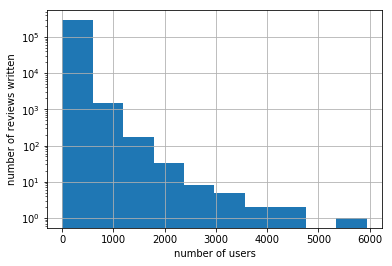

In [28]:
reviews_by_user_count['count'].hist(log=True)
plt.xlabel('number of users')
plt.ylabel('number of reviews written')

Most of the users have between 0-500 reviews, however there are some enthusiasts with >4000 reviews! That's some real dedication right there! User 'leffe dubbel' has rated in total 5984 games, just wow!

In [29]:
# select users that reviewed more than cutoff games
cutoff = 500
active_users = reviews_by_user_count[reviews_by_user_count['count']>cutoff]
active_users = active_users['user']
reviews_by_active_users = reviews[reviews['user'].isin(active_users)]
print(len(reviews_by_active_users))
reviews_by_active_users.head()

2061201


,user,rating,comment,ID,name
3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,ssmooth,10.0,NaN,13,Catan
17,Thesp,10.0,One of the best games ever created. Period. Ne...,13,Catan
37,cfarrell,10.0,THE classic game of the 90's. Belongs in every...,13,Catan
49,oobydoob,10.0,NaN,13,Catan


In [30]:
count_user, count_review = reviews[['user','name']].nunique()
print('density',len(reviews)/(count_user*count_review))
count_user, count_review = reviews_by_active_users[['user','name']].nunique()
print('density', len(reviews_by_active_users)/(count_user*count_review))

density 0.002714530811444581
density 0.04631749779929073


In [31]:
games_rated_by_active_users = reviews_by_active_users.groupby('name')['rating'].agg(['mean','count']).sort_values('mean',ascending=False)
games_rated_by_active_users['rank']=games_rated_by_active_users.reset_index().index+1

print('{} users original, with {} reviews'.format(reviews['user'].nunique(),len(reviews)))
print('{} users left({}% of the userbase), with {} reviews (this is {} of all reviews)'.format(len(active_users),len(active_users)/reviews['user'].nunique(),len(reviews_by_active_users),len(reviews_by_active_users)/len(reviews)))

289913 users original, with 13170073 reviews
2667 users left(0.00919931151759321% of the userbase), with 2061201 reviews (this is 0.15650642179432112 of all reviews)


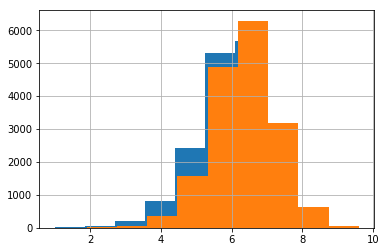

In [32]:
games_rated_by_active_users['mean'].hist()
games_by_all_users['mean'].hist()

Games seem to get a slightly higher shore when rated by all users

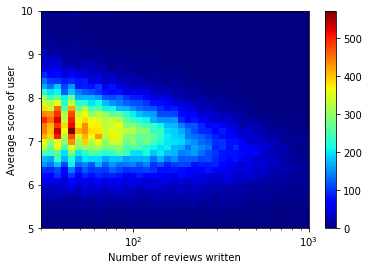

In [33]:
x = reviews_by_user_count['count']
y = reviews_by_user_count['mean']
plt.xscale('log')

plt.hist2d(x, y, bins=[np.logspace(np.log10(30),np.log10(1000),40),np.linspace(5,10,num=40)], cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('Number of reviews written')
plt.ylabel('Average score of user')
plt.show()

This graph shows that users with many reviews tend to give lower scores compared to users that are less active (r2=0.09). Two explainations arise:
- Active users simply rate more games, so they also play more bad games. Vice versa, casual users just play good games
- Active users are more critical of games, so tend to give lower scores

In [34]:
merge = games_rated_by_active_users[['mean','count']].merge(games_by_all_users[['name','mean','count', 'Geekscore']],how='outer',left_index=True, right_on=['name'],suffixes=('active','all'),indicator=True)

merge['delta_active_all']=merge['meanactive']-merge['meanall']
merge['proportion_active']=merge['countactive']/merge['countall']
merge.sort_values('countall',ascending=False)[:5]

,meanactive,countactive,name,meanall,countall,Geekscore,_merge,delta_active_all,proportion_active
2862,6.773954,2491.0,Catan,7.211526,84498,7.036,both,-0.437571,0.029480
1881,7.028272,2516.0,Carcassonne,7.426518,84464,7.321,both,-0.398246,0.029788
1224,7.175587,2501.0,Pandemic,7.640045,82816,7.545,both,-0.464458,0.030199
857,7.439337,2530.0,7 Wonders,7.783037,68614,7.689,both,-0.343701,0.036873
1199,7.394145,2525.0,Dominion,7.646263,67955,7.544,both,-0.252118,0.037157


In [35]:
merge['delta_active_all'].median()

-0.3338065715526368

The active users with >500 reviews per user make up 1% of the userbase, but almost submit 15% of all the reviews. Their scores per game are about 0.33 points lower compared to the whole population. To me this suggests they are more critical, since we are comparing per game. E.g. Catan has a mean score of 7.21 (meanall), but a mean score of 6.79 by the active users, leading to a delta of 0.43 (delta_active_all). Furthermore, the reviews of active users make up 3% of the reviews for Catan (proportion_active)

In [36]:
corr = merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,meanactive,countactive,meanall,countall,Geekscore,delta_active_all,proportion_active
meanactive,1,0.24791,0.825443,0.17257,0.480093,0.396745,-0.0196527
countactive,0.24791,1,0.233471,0.822122,0.765531,0.0514668,-0.108296
meanall,0.825443,0.233471,1,0.18753,0.516819,-0.190668,-0.231062
countall,0.17257,0.822122,0.18753,1,0.604574,-0.0068467,-0.19093
Geekscore,0.480093,0.765531,0.516819,0.604574,1,-0.0101992,-0.213308
delta_active_all,0.396745,0.0514668,-0.190668,-0.0068467,-0.0101992,1,0.341562
proportion_active,-0.0196527,-0.108296,-0.231062,-0.19093,-0.213308,0.341562,1


Aside from the obvious correlations between the set of reviews by active users and all reviews, a few things stand out:
- The geekscore has a higher correlation with the number of reviews (count) than the average score given (mean). Is this is problem?
- The more the reviews of games consist of active users, the lower the score (fairly low negative correlation)

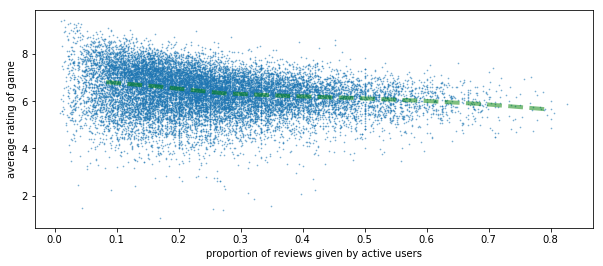

In [37]:
y = merge['meanall']
x = merge['proportion_active']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.linspace(0,1,num=10))   
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel('proportion of reviews given by active users')
plt.ylabel('average rating of game')
plt.show()

Here you see the small effect that active users have on a lower average score of a game

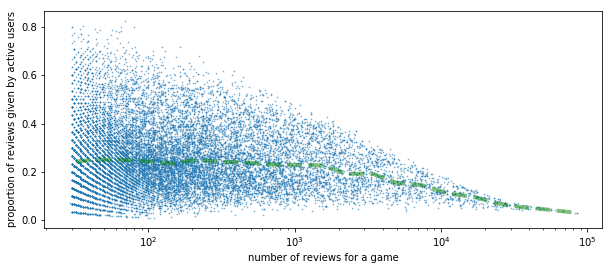

In [38]:
x = merge['countall']
y = merge['proportion_active']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.logspace(0,5,num=30))           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel('number of reviews for a game')
plt.ylabel('proportion of reviews given by active users')
plt.show()

This makes sense, since games like Catan that have a huge number of reviews (85268) by majority are rated by casual users, since there are only about 2700 active users with >500 reviews.

A more 'clean' way to investigate this is to investigate per game how active it userbase is. How active users are can be defined by the mean number of reviews of the userbase.

In [39]:
merged_reviews = reviews.merge(reviews_by_user_count,how='left',on='user',suffixes=('','user'),indicator=True)
games_test = merged_reviews.groupby('name')[['rating','count']].agg(['mean','median','count']).sort_values(('count', 'count'),ascending=False)
games_test[:5]

rating                     count              
                 mean median  count        mean median  count
name                                                         
Catan        7.211526    7.0  84498  104.361255   51.0  84497
Carcassonne  7.426518    7.5  84464  107.853782   55.0  84463
Pandemic     7.640045    8.0  82816  109.880204   57.0  82816
7 Wonders    7.783037    8.0  68614  124.580844   67.0  68614
Dominion     7.646263    8.0  67955  123.100906   65.0  67954

Catan has a mean rating of 7.2, with median score of 7.0 and 84613 reviews. The users that reviewed it rated on average 105 games, with a median of 51.
The median is the best metric to gauge how active the users are, since it filters away the effect of extremely active users on the mean.

In [40]:
corr = games_test.corr()
corr.style.background_gradient(cmap='coolwarm')

Again, positive correlations for the number of reviews and scores, and negative correlations for the activity of the users that rated a game and the score

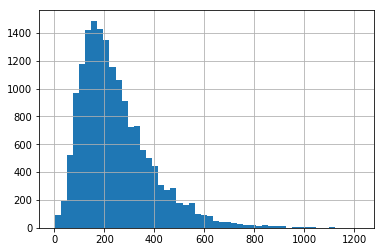

In [41]:
games_test['count','median'].hist(bins=50)

Nice distribution, lets investigate.

In [42]:
games_test = games_test.sort_values(('count', 'median'),ascending=True)
games_test[games_test['rating', 'count']>0][:30]

rating                    count  \
                                             mean median count        mean   
name                                                                         
TerroriXico                              9.428571  10.00    70   62.800000   
Gladiatoris                              9.001515   9.50    33  116.696970   
Battle Gnomes                            8.720588  10.00    34   53.294118   
Animator vs Animation                    9.588235  10.00    34    8.323529   
Borders of Kanta                         8.985294   9.00    34   37.823529   
Ciudad de Cartón                         8.985714  10.00    35   25.485714   
Goblin Grapple                           8.733750   9.00   168   61.619048   
Demon Espionage                          7.795455   8.50    44   58.363636   
Clutch Baseball                          8.630682  10.00    44   44.477273   
El Dorado Canyon                         8.502500   9.00    32  211.625000   
90°                                      7.547170   9.00    53   61.754717   
War Titans: Invaders Must Die!           9.129032  10.00    62   29.903226   
Ignite                                   9.027273  10.00    55   92.472727   
Meeple Quest                             9.255319  10.00    47  116.170213   
Arena: The Contest                       9.409091  10.00    99   32.494949   
Limbo: Eternal War                       9.597143  10.00    35    5.857143   
Human Interface: Be a Better Human       9.000000  10.00    38   87.631579   
Vilar de Mouros                          8.456129   8.00    31  131.322581   
Role Quest                               8.277778   8.00    36   49.222222   
Anno Domini 1666                         9.018519   9.00    54   25.055556   
Assassin's Creed: Brotherhood of Venice  8.735366   9.00    82   36.707317   
The Everrain                             8.721667  10.00    30   23.133333   
Kill The Unicorns                        7.883738   8.00   206  131.189320   
Dungeon Universalis                      8.814694  10.00    49   87.040816   
Dungeonology: The Expedition             8.950000  10.00    70   66.485714   
Gruff: Stuff of Nightmares               8.656897   9.00    58  110.793103   
Disastles                                7.844737   8.00    38  223.184211   
Twistocity                               8.531579   9.75    38  224.026316   
Win, Don't Lose                          7.872312   9.00    32  199.000000   
Warlords of Terra                        8.741667  10.00    30   60.366667   

                                                      
                                        median count  
name                                                  
TerroriXico                                1.0    70  
Gladiatoris                                1.0    33  
Battle Gnomes                              1.0    34  
Animator vs Animation                      1.0    34  
Borders of Kanta                           1.0    34  
Ciudad de Cartón                           1.0    35  
Goblin Grapple                             1.0   168  
Demon Espionage                            1.0    44  
Clutch Baseball                            1.0    44  
El Dorado Canyon                           1.0    32  
90°                                        1.0    53  
War Titans: Invaders Must Die!             1.0    62  
Ignite                                     1.0    55  
Meeple Quest                               2.0    47  
Arena: The Contest                         2.0    99  
Limbo: Eternal War                         2.0    35  
Human Interface: Be a Better Human         2.0    38  
Vilar de Mouros                            2.0    31  
Role Quest                                 3.0    36  
Anno Domini 1666                           3.0    54  
Assassin's Creed: Brotherhood of Venice    3.0    82  
The Everrain                               3.5    30  
Kill The Unicorns                          4.0   206  
Dungeon Universalis                   

The wall of shame: these games are all reviewed by users that are suspiciously inactive. Probably rated by fake accounts. But also not so many reviews. Kill the unicorns managed to get 200 though, with an median user that reviewed only 4 games.

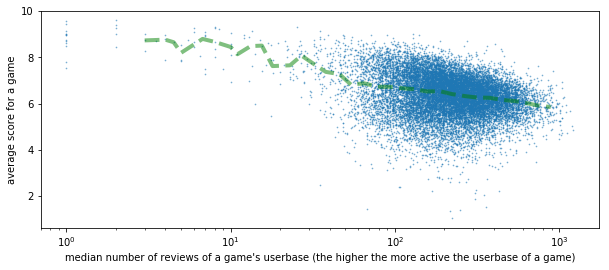

In [43]:
y = games_test[games_test['rating', 'count']>0]['rating', 'mean']
x = games_test[games_test['rating', 'count']>0]['count', 'median']

df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.logspace(0,3,num=40))   
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel("median number of reviews of a game's userbase (the higher the more active the userbase of a game)")
plt.ylabel('average score for a game')
plt.show()

The more active the userbase, the lower the average score a game receives.

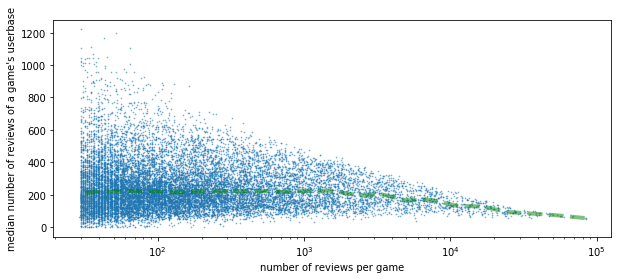

In [44]:
x = games_test['rating', 'count']
y = games_test['count', 'median']


df = pd.DataFrame({'X' : x, 'Y' : y})  #we build a dataframe from the data
data_cut = pd.cut(df.X,bins=np.logspace(0,5,num=30))   
grp = df.groupby(by = data_cut)        #we group the data by the cut
ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin

#plotting
plt.figure(num=None, figsize=(10, 4), facecolor='w', edgecolor='k')
plt.xscale('log')
plt.scatter(df.X,df.Y,alpha=.5,s=0.5)
plt.plot(ret.X,ret.Y,'g--',lw=4,alpha=0.5)
plt.xlabel('number of reviews per game')
plt.ylabel("median number of reviews of a game's userbase")
plt.show()

Here you see the effect again of games with a very high amount of ratings.

All in all, making causal inferences based on a historical data is like threading on thin ice. I do think experienced users give lower ratings, so are more critical. But concluding that games are ending up with a lower average rating because of these experienced reviewers is probably a step too far.

That's it. I enjoyed making my first dataset and kernel. Would appreciate any comments!!